<a href="https://colab.research.google.com/github/Mehulgoyal353/CODSOFT/blob/main/Movie_Rating_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [4]:
data = pd.read_csv('/content/IMDb Movies India.csv', encoding='ISO-8859-1')

data.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
print(data.isnull().sum())


Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64


In [6]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

Name         0.000000
Year         3.404475
Duration    53.317429
Genre       12.102650
Rating      48.939326
Votes       48.932878
Director     3.385131
Actor 1     10.426204
Actor 2     15.371720
Actor 3     20.272100
dtype: float64


In [7]:
threshold = 50
columns_to_drop = missing_percentage[missing_percentage > threshold].index
data.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns: {columns_to_drop}")

Dropped columns: Index(['Duration'], dtype='object')


In [8]:
data['Year'] = data['Year'].astype(str).str.replace(r'[^0-9]', '', regex=True)
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
data['Year'].fillna(0, inplace=True)
data['Year'] = data['Year'].astype(int)

<ipython-input-8-246086623>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Year'].fillna(0, inplace=True)


In [9]:
data['Year']


,Year
0,0
1,2019
2,2021
3,2019
4,2010
...,...
15504,1988
15505,1999
15506,2005
15507,1988


In [10]:
data['Rating'].fillna(0, inplace=True)
data['Votes'] = data['Votes'].astype(str).str.replace(',', '', regex=True)
data['Votes'] = pd.to_numeric(data['Votes'], errors='coerce')
data['Votes'].fillna(0, inplace=True)

<ipython-input-10-3410429509>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Rating'].fillna(0, inplace=True)
<ipython-input-10-3410429509>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({

In [11]:
numerical_columns = ['Year', 'Votes', 'Rating']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col].fillna(data[col].median(), inplace=True)

# Check for remaining NaNs in numerical columns
print("Remaining NaNs in numerical columns:")
print(data[numerical_columns].isnull().sum())

Remaining NaNs in numerical columns:
Year      0
Votes     0
Rating    0
dtype: int64


<ipython-input-11-406355108>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [12]:
q1 = np.percentile(data['Votes'], 25)
q3 = np.percentile(data['Votes'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data = data[(data['Votes'] >= lower_bound) & (data['Votes'] <= upper_bound)]

In [13]:
categorical_columns = ['Genre', 'Actor 1', 'Actor 2', 'Actor 3', 'Director']
for col in categorical_columns:
    data[col].fillna('Unknown', inplace=True)

top_n = 20
for col in categorical_columns:
    top_categories = data[col].value_counts().nlargest(top_n).index
    data[col] = data[col].apply(lambda x: x if x in top_categories else 'Other')

data['Director_Avg_Rating'] = data.groupby('Director')['Rating'].transform('mean')
data['Actor_1_Popularity'] = data.groupby('Actor 1')['Actor 1'].transform('count')

# Handle missing values
data['Director_Avg_Rating'].fillna(data['Director_Avg_Rating'].median(), inplace=True)
data['Actor_1_Popularity'].fillna(data['Actor_1_Popularity'].median(), inplace=True)



encoded_data = pd.get_dummies(data[categorical_columns], drop_first=True)

# Concatenate encoded columns back to the dataset
data = pd.concat([data, encoded_data], axis=1).drop(categorical_columns, axis=1)

<ipython-input-13-1019339906>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna('Unknown', inplace=True)
<ipython-input-13-1019339906>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

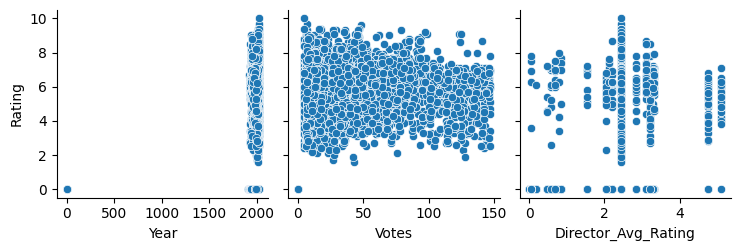

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot relationships between features and target
sns.pairplot(data, x_vars=['Year', 'Votes', 'Director_Avg_Rating'], y_vars='Rating', kind='scatter')
plt.show()

In [15]:
# Select relevant features
X = data[['Year', 'Votes', 'Director_Avg_Rating', 'Actor_1_Popularity']]
y = data['Rating']

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA(n_components=0.80)  # Retain 80% of the variance
X_pca_reduced = pca.fit_transform(X_scaled)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [20]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.6842860076331778
R-squared: 0.9210129844461039


In [21]:
y_train_pred = model.predict(x_train)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training R²: {train_r2}')

# Evaluate on test data
test_r2 = r2_score(y_test, y_pred)
print(f'Test R²: {test_r2}')

Training R²: 0.9760319213945483
Test R²: 0.9210129844461039


In [22]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f'Cross-Validation R² Scores: {scores}')
print(f'Mean R²: {scores.mean()}')

Cross-Validation R² Scores: [0.92693767 0.92910525 0.91751442 0.92512642 0.92415038]
Mean R²: 0.924566826996467
